## San Diego COVID-19 projections

Description


In [1]:
import sys
# Install required packages
!{sys.executable} -mpip -q install matplotlib seaborn statsmodels pandas publicdata metapack

%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np
import metapack as mp
import rowgenerators as rg
import publicdata as pub
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from sklearn import  linear_model

In [2]:

pkg = mp.open_package('http://library.metatab.org/sandiegodata.org-covid19-1.2.0.csv') # .0 references the last upload
df = pkg.resource('sd_covid_cases').dataframe().fillna(0)
df.drop(columns=['notes'], inplace=True)
df['date'] = pd.to_datetime(df.date)
df['cases_rate'] = (df.cases - df.cases.shift(1))/ df.cases.shift(1)
df['hosp_rate'] = (df.hospitalized - df.hospitalized.shift(1))/ df.hospitalized.shift(1)
df['death_rate'] = (df.deaths - df.deaths.shift(1))/ df.deaths.shift(1)
df['mean_cases_rate'] = df.cases_rate.rolling(5).mean()
df =df.dropna(subset=['cases_rate'])
df['double_days'] = np.log(2)/np.log(1+df.mean_cases_rate)
df.head().T

,1,2,3,4,5
date,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00,2020-03-17 00:00:00
cases,10,20,39,55,60
cases_male,0,0,19,35,39
cases_female,0,0,20,20,21
hospitalized,0,0,12,10,10
intensive_care,0,0,0,0,0
deaths,0,0,0,0,0
cases_rate,0.25,1,0.95,0.410256,0.0909091
hosp_rate,NaN,NaN,inf,-0.166667,0
death_rate,NaN,NaN,NaN,NaN,NaN


In [3]:
df

,date,cases,cases_male,cases_female,hospitalized,intensive_care,deaths,cases_rate,hosp_rate,death_rate,mean_cases_rate,double_days
1,2020-03-13,10,0.0,0.0,0.0,0.0,0.0,0.250000,NaN,NaN,NaN,NaN
2,2020-03-14,20,0.0,0.0,0.0,0.0,0.0,1.000000,NaN,NaN,NaN,NaN
3,2020-03-15,39,19.0,20.0,12.0,0.0,0.0,0.950000,inf,NaN,NaN,NaN
4,2020-03-16,55,35.0,20.0,10.0,0.0,0.0,0.410256,-0.166667,NaN,NaN,NaN
5,2020-03-17,60,39.0,21.0,10.0,0.0,0.0,0.090909,0.000000,NaN,0.540233,1.604753
6,2020-03-18,80,53.0,27.0,11.0,0.0,0.0,0.333333,0.100000,NaN,0.556900,1.565739
7,2020-03-19,105,67.0,36.0,13.0,0.0,0.0,0.312500,0.181818,NaN,0.419400,1.979097
8,2020-03-20,131,85.0,45.0,27.0,0.0,0.0,0.247619,1.076923,NaN,0.278924,2.817457
9,2020-03-21,159,104.0,54.0,34.0,13.0,0.0,0.213740,0.259259,NaN,0.239620,3.226864
10,2020-03-22,205,133.0,71.0,41.0,15.0,1.0,0.289308,0.205882,inf,0.279300,2.814089


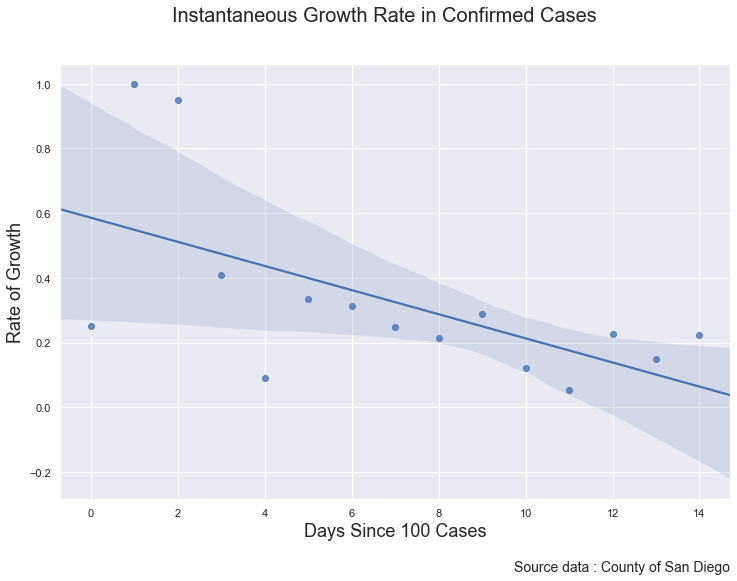

Coefficients: [[-0.03728801]] [0.58568852]
Zero growth at 15.707152846765846 days


In [4]:
start_date = df.iloc[0].date
start_cases = df.iloc[0].cases
df['day'] = (df.date - start_date).dt.days

def plot_gr(df, col):

    x = df.day.values.reshape(len(df), 1)
    y = df[col].values.reshape(len(df), 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    fig, ax = plt.subplots(figsize=(12,8))
    fig.suptitle('Instantaneous Growth Rate in Confirmed Cases',fontsize=20)

    sns.regplot(ax=ax, x='day',y=col, data=df)

    #ax.plot(x, regr.predict(x), color='blue', linewidth=3)

    ax.set_xlabel('Days Since 100 Cases', fontsize=18)
    ax.set_ylabel('Rate of Growth', fontsize=18)

   
    plt.gcf().text(.65,0, f"Source data : County of San Diego", fontsize=14) 
    plt.show()

    print('Coefficients:', regr.coef_, regr.intercept_)

    m = regr.coef_[0][0]
    b = regr.intercept_[0]

    print(f"Zero growth at {-b/m} days")

plot_gr(df, 'cases_rate')
    

In [5]:
df.day.corr(df.cases_rate)

-0.5947145204879525

In [6]:
import statsmodels.api as sm
t = df.iloc[3:]
x = t.day.values.reshape(len(t), 1)
y = t.cases_rate.values.reshape(len(t), 1)
X = sm.add_constant(x)
mod = sm.OLS(y, X)
res = mod.fit()
print (res.conf_int(0.1))  

b, m = res.params

(bs, ms) = res.conf_int(0.1)
-bs[0]/ms[1], -b/m, -bs[1]/ms[0]


[[ 0.20169757  0.47463253]
 [-0.02848188  0.00126827]]


(-159.03401434913877, 24.852640053119863, 16.66436866479989)

Empty DataFrame
Columns: [days, growth, cases]
Index: []


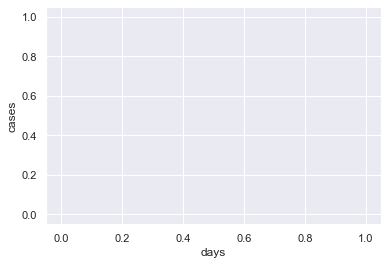

In [7]:
days = list(range( int(-bs[0]/ms[1]) + 5))

b = bs[0]
m = ms[1]

growth = [ m*x+b for x in days ]

def gen_cases(start):
    
    for r in growth:
        yield start
        
        if r < 0:
            r = 0
        start += start * r
      
        

t = pd.DataFrame({
    'days':days,
    'growth':growth,
    'cases': list(gen_cases(start_cases))
})
print(t.head())
sns.lineplot(x='days',y='cases', data=t)

In [8]:
t['double_days'] = np.log(2)/np.log(1+t.growth)
t['date'] = t.days.apply( lambda v: start_date + pd.Timedelta(days=v))
t

,days,growth,cases,double_days,date


In [9]:
df[['date', 'cases', 'double_days']].iloc[5:]

,date,cases,double_days
6,2020-03-18,80,1.565739
7,2020-03-19,105,1.979097
8,2020-03-20,131,2.817457
9,2020-03-21,159,3.226864
10,2020-03-22,205,2.814089
11,2020-03-23,230,3.258675
12,2020-03-24,242,4.084357
13,2020-03-25,297,4.168860
14,2020-03-26,341,4.469130
15,2020-03-27,417,4.825133


In [10]:
t[['date', 'cases', 'double_days']].loc[13:21]

,date,cases,double_days


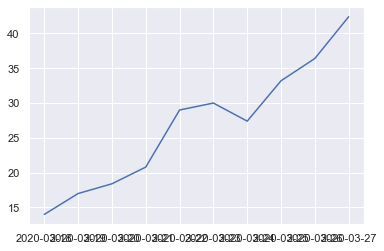

In [11]:

t = df.copy()
t['diff'] = t.cases.rolling(5).mean().diff().dropna()
plt.plot(t.date, t['diff'])